In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [3]:
chipotle_df = pd.read_csv('data/chipotle_stores.csv')

In [8]:
us_states = gpd.read_file('data/us-states.json')

In [7]:
# Convert chipotle data to geo data frame
chipotle_gdf = gpd.GeoDataFrame(
    chipotle_df, 
    geometry=gpd.points_from_xy(chipotle_df.longitude, chipotle_df.latitude),
    crs='EPSG:4326')

chipotle_gdf.head()

state    location                                    address   latitude  \
0  Alabama      Auburn     346 W Magnolia Ave Auburn, AL 36832 US  32.606813   
1  Alabama  Birmingham      300 20th St S Birmingham, AL 35233 US  33.509721   
2  Alabama  Birmingham     3220 Morrow Rd Birmingham, AL 35235 US  33.595581   
3  Alabama  Birmingham   4719 Highway 280 Birmingham, AL 35242 US  33.422582   
4  Alabama     Cullman  1821 Cherokee Ave SW Cullman, AL 35055 US  34.154134   

   longitude  Cluster                    geometry  
0 -85.487328        2  POINT (-85.48733 32.60681)  
1 -86.802756        2  POINT (-86.80276 33.50972)  
2 -86.647437        2  POINT (-86.64744 33.59558)  
3 -86.698279        2  POINT (-86.69828 33.42258)  
4 -86.841220        2  POINT (-86.84122 34.15413)

# K-means Clustering

### Select features

In [4]:
X = chipotle_df[['latitude', 'longitude']].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Find Optimal Number of Clusters

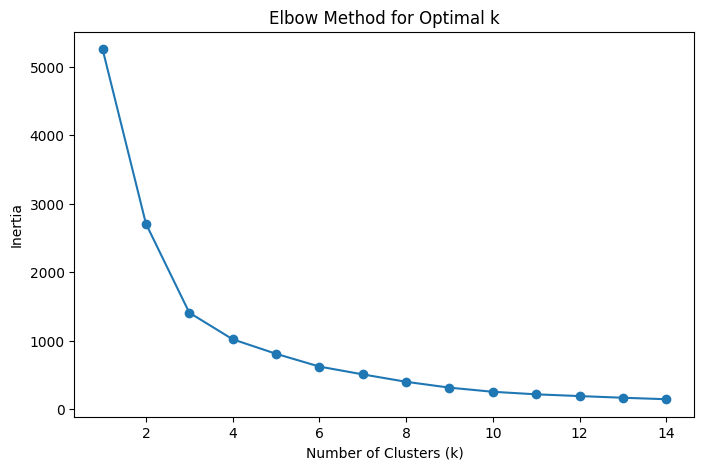

In [5]:
# Find the optimal k using the Elbow Method
inertia = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


Looks like 4 or 5 is the best balance between compact clusters and not overfitting.


Decided on 10 clusters. Considering we are working with geographic data, less clusters place the centroids in odd places and aren't useful. 10 seems like a good compromise.

### Apply K-means with Optimal k

In [16]:
# Set k (adjust based on elbow method result)
optimal_k = 10

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
chipotle_df["Cluster"] = kmeans.fit_predict(X_scaled)

# Assign cluster centers back to original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)


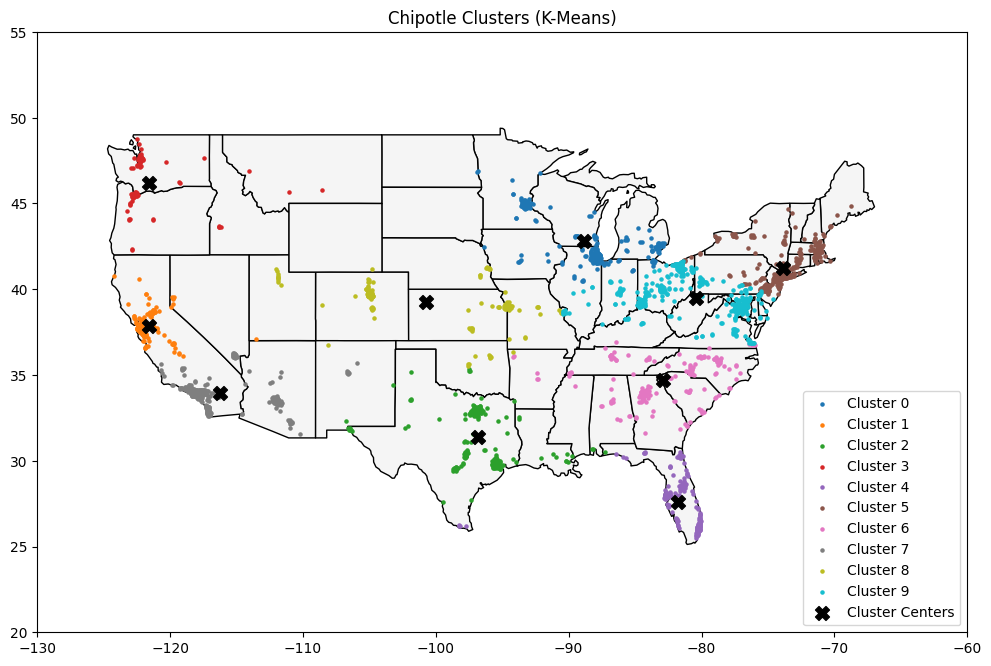

In [17]:
# Create a GeoDataFrame with cluster labels
chipotle_gdf["Cluster"] = chipotle_df["Cluster"]

us_states = us_states.to_crs(epsg=4326) 

# Plot the clusters
fig, ax = plt.subplots(figsize=(12, 8))
us_states.plot(ax=ax, color="whitesmoke", edgecolor="black")

# Plot Chipotle locations with cluster colors
for cluster in range(optimal_k):
    cluster_points = chipotle_gdf[chipotle_gdf["Cluster"] == cluster]
    cluster_points.plot(ax=ax, markersize=5, label=f"Cluster {cluster}")

# Set axis limits to focus on the continental US (ignore Alaska/Hawaii)
ax.set_xlim([-130, -60])  # Longitude limits
ax.set_ylim([20, 55])  # Latitude limits

# Plot cluster centers
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c="black", marker="X", s=100, label="Cluster Centers")

plt.legend()
plt.title("Chipotle Clusters (K-Means)")
plt.show()


In [19]:
# Create a Folium map
kmeans_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Define cluster colors
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "gray", "cyan", "yellow"]

# Add Chipotle locations to the map with cluster colors
for _, row in chipotle_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=colors[row["Cluster"] % len(colors)],
        fill=True,
        fill_color=colors[row["Cluster"] % len(colors)],
        fill_opacity=0.7,
    ).add_to(kmeans_map)

# Add cluster centers
for lat, lon in cluster_centers:
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color="black", icon="star"),
    ).add_to(kmeans_map)

# Save and display
kmeans_map.save("kmeans_clusters.html")
kmeans_map


In [21]:
# Count the number of stores in each cluster
cluster_counts = chipotle_df["Cluster"].value_counts().sort_index()

# Display the counts
cluster_counts


Cluster
0    301
1    165
2    240
3     82
4    180
5    402
6    201
7    377
8    172
9    509
Name: count, dtype: int64

C:\Users\T570\AppData\Local\Temp\ipykernel_2144\324037273.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


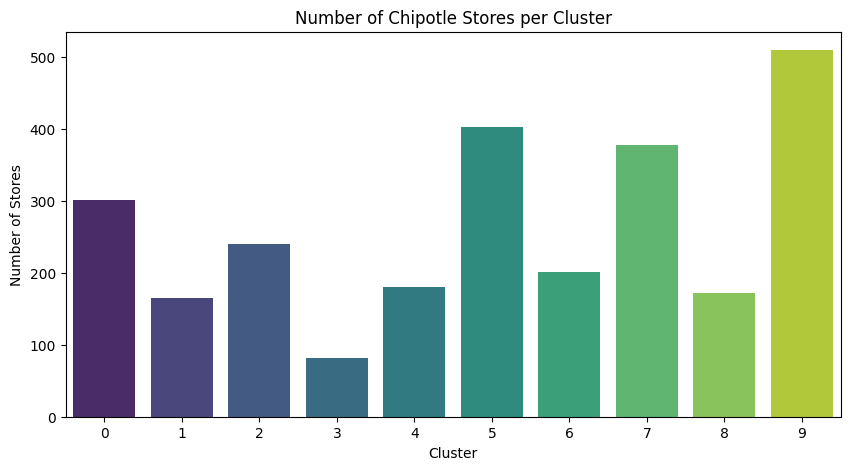

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of stores per cluster
plt.figure(figsize=(10, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Stores")
plt.title("Number of Chipotle Stores per Cluster")
plt.show()


# DBSCAN

- Doesn’t require pre-setting the number of clusters (k).
- Better at detecting dense regions while marking outliers/noise.
- More realistic for geographical data compared to K-Means.
- Handles irregular shapes (useful if Chipotle locations form dense pockets in cities but are sparse in rural areas).

Already scaled data during K-means clustering

### Choose eps

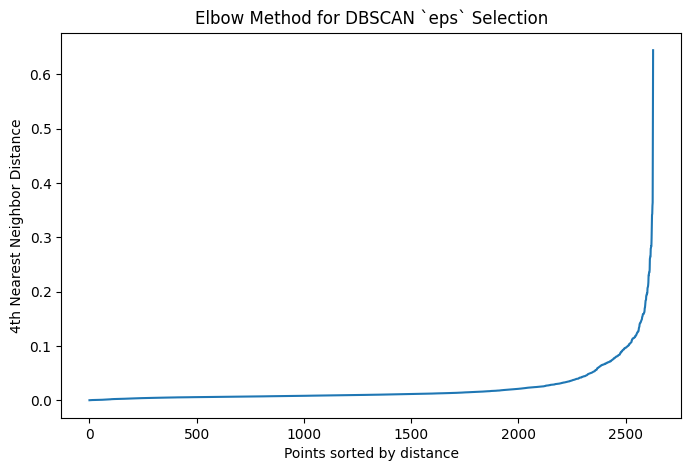

In [26]:
# Find the 4 nearest neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the distances
distances = np.sort(distances[:, 3])  # Get the 4th nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("Elbow Method for DBSCAN `eps` Selection")
plt.show()

In [27]:
# Define DBSCAN with estimated `eps`
eps_value = 0.2
min_samples_value = 5 

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
chipotle_df["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled)

# Count number of points in each cluster
dbscan_clusters = chipotle_df["DBSCAN_Cluster"].value_counts().sort_index()
print(dbscan_clusters)


DBSCAN_Cluster
-1       29
 0     1393
 1      398
 2      534
 3       25
 4       80
 5       75
 6        6
 7        8
 8       34
 9       10
 10      37
Name: count, dtype: int64


DBScan identified 10 clusters so this confirms my insticts were correct earlier.

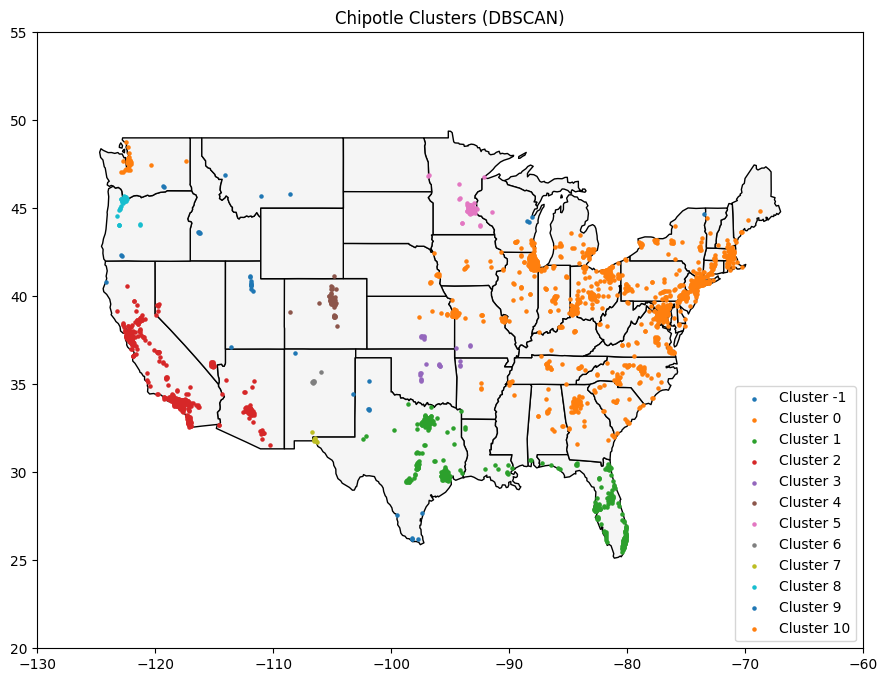

In [28]:
# Convert to GeoDataFrame
chipotle_gdf["DBSCAN_Cluster"] = chipotle_df["DBSCAN_Cluster"]

# Plot DBSCAN clusters
fig, ax = plt.subplots(figsize=(12, 8))
us_states.plot(ax=ax, color="whitesmoke", edgecolor="black")

# Plot each cluster in a different color
for cluster in sorted(chipotle_df["DBSCAN_Cluster"].unique()):
    cluster_points = chipotle_gdf[chipotle_gdf["DBSCAN_Cluster"] == cluster]
    cluster_points.plot(ax=ax, markersize=5, label=f"Cluster {cluster}")

# Set axis limits to focus on the continental US (ignore Alaska/Hawaii)
ax.set_xlim([-130, -60])  # Longitude limits
ax.set_ylim([20, 55])  # Latitude limits

plt.title("Chipotle Clusters (DBSCAN)")
plt.legend()
plt.show()


In [29]:
import folium

# Create a Folium map
dbscan_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Define colors
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "gray", "cyan", "yellow"]

# Add Chipotle locations with DBSCAN cluster colors
for _, row in chipotle_df.iterrows():
    cluster_id = row["DBSCAN_Cluster"]
    color = colors[cluster_id % len(colors)] if cluster_id != -1 else "black"  # Black for noise

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(dbscan_map)

# Save and display
dbscan_map.save("dbscan_clusters.html")
dbscan_map


In [30]:
#Finding the Most Representative Point per Cluster


from scipy.spatial.distance import cdist
import numpy as np

# Get unique DBSCAN clusters (excluding noise, which is labeled -1)
dbscan_clusters = chipotle_df["DBSCAN_Cluster"].unique()
dbscan_clusters = dbscan_clusters[dbscan_clusters != -1]  # Remove noise cluster

# Find representative points for each cluster
rep_points = []
for cluster in dbscan_clusters:
    cluster_points = chipotle_df[chipotle_df["DBSCAN_Cluster"] == cluster][["latitude", "longitude"]].values
    if len(cluster_points) > 0:
        # Compute distance between all points in cluster
        distance_matrix = cdist(cluster_points, cluster_points, metric="euclidean")
        # Find the most central point (smallest sum of distances to all other points)
        central_idx = np.argmin(distance_matrix.sum(axis=1))
        rep_points.append(cluster_points[central_idx])

# Convert representative points to a DataFrame
rep_points_df = pd.DataFrame(rep_points, columns=["latitude", "longitude"])
rep_points_df["Cluster"] = range(len(rep_points))

# Display representative points
print(rep_points_df)


     latitude   longitude  Cluster
0   39.628094  -79.957707        0
1   30.115376  -94.169283        1
2   34.151687 -118.080201        2
3   36.140805  -95.968657        3
4   39.718560 -104.949561        4
5   44.973648  -93.275381        5
6   35.174939 -106.574971        6
7   31.817055 -106.427560        7
8   45.420446 -122.739203        8
9   40.725525 -111.862037        9
10  47.613550 -122.199784       10


In [32]:
# Add representative cluster points to the DBSCAN map
for _, row in rep_points_df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=folium.Icon(color="black", icon="star"),
        popup=f"DBSCAN Cluster {row['Cluster']}"
    ).add_to(dbscan_map)

# Save and display updated DBSCAN map
dbscan_map.save("dbscan_clusters_with_representative_points.html")
dbscan_map


# HDBSCAN
This method divides the area into grids and clusters based on density within each grid cell.

In [33]:
import hdbscan

# Apply HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=10, metric="euclidean")
chipotle_df["HDBSCAN_Cluster"] = hdb.fit_predict(X_scaled)

# Count clusters
print(chipotle_df["HDBSCAN_Cluster"].value_counts())


HDBSCAN_Cluster
-1     491
 13    222
 38    188
 27    157
 41    104
 3      99
 0      88
 19     87
 33     73
 14     72
 5      71
 37     66
 35     64
 8      64
 9      61
 39     56
 24     53
 36     42
 21     41
 12     37
 2      36
 16     34
 1      31
 26     30
 31     30
 18     29
 17     28
 10     24
 4      24
 32     23
 25     23
 40     20
 28     19
 29     17
 34     17
 6      16
 23     16
 30     16
 11     15
 22     13
 7      12
 20     10
 15     10
Name: count, dtype: int64


c:\Users\T570\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\T570\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [34]:
# Count number of stores per cluster
hdbscan_clusters = chipotle_df["HDBSCAN_Cluster"].value_counts().sort_index()
print(hdbscan_clusters)


HDBSCAN_Cluster
-1     491
 0      88
 1      31
 2      36
 3      99
 4      24
 5      71
 6      16
 7      12
 8      64
 9      61
 10     24
 11     15
 12     37
 13    222
 14     72
 15     10
 16     34
 17     28
 18     29
 19     87
 20     10
 21     41
 22     13
 23     16
 24     53
 25     23
 26     30
 27    157
 28     19
 29     17
 30     16
 31     30
 32     23
 33     73
 34     17
 35     64
 36     42
 37     66
 38    188
 39     56
 40     20
 41    104
Name: count, dtype: int64


In [37]:
# Create a Folium map
hdbscan_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Define colors
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "gray", "cyan", "yellow"]

# Add Chipotle locations with cluster colors
for _, row in chipotle_df.iterrows():
    cluster_id = row["HDBSCAN_Cluster"]
    color = colors[cluster_id % len(colors)] if cluster_id != -1 else "black"  # Black for noise

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(hdbscan_map)

# Save and display
hdbscan_map.save("hdbscan_clusters.html")
hdbscan_map


In [38]:
from folium.plugins import HeatMap

# Create a heatmap map for Chipotle store density by HDBSCAN cluster
density_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add heatmap layer
HeatMap(data=chipotle_df[["latitude", "longitude"]].values, radius=10).add_to(density_map)

# Save and display
density_map.save("hdbscan_density_heatmap.html")
density_map


# Compare K-means, DBscan & HDBscan

In [39]:
# Count clusters for each method
print("K-Means Clusters:", chipotle_df["Cluster"].nunique())
print("DBSCAN Clusters:", chipotle_df["DBSCAN_Cluster"].nunique(), "(includes noise)")
print("HDBSCAN Clusters:", chipotle_df["HDBSCAN_Cluster"].nunique(), "(includes noise)")


K-Means Clusters: 10
DBSCAN Clusters: 12 (includes noise)
HDBSCAN Clusters: 43 (includes noise)


In [40]:
# Count stores per cluster
kmeans_counts = chipotle_df["Cluster"].value_counts()
dbscan_counts = chipotle_df["DBSCAN_Cluster"].value_counts()
hdbscan_counts = chipotle_df["HDBSCAN_Cluster"].value_counts()

# Display cluster sizes
print("\nK-Means Cluster Sizes:\n", kmeans_counts)
print("\nDBSCAN Cluster Sizes:\n", dbscan_counts)
print("\nHDBSCAN Cluster Sizes:\n", hdbscan_counts)



K-Means Cluster Sizes:
 Cluster
9    509
5    402
7    377
0    301
2    240
6    201
4    180
8    172
1    165
3     82
Name: count, dtype: int64

DBSCAN Cluster Sizes:
 DBSCAN_Cluster
 0     1393
 2      534
 1      398
 4       80
 5       75
 10      37
 8       34
-1       29
 3       25
 9       10
 7        8
 6        6
Name: count, dtype: int64

HDBSCAN Cluster Sizes:
 HDBSCAN_Cluster
-1     491
 13    222
 38    188
 27    157
 41    104
 3      99
 0      88
 19     87
 33     73
 14     72
 5      71
 37     66
 35     64
 8      64
 9      61
 39     56
 24     53
 36     42
 21     41
 12     37
 2      36
 16     34
 1      31
 26     30
 31     30
 18     29
 17     28
 10     24
 4      24
 32     23
 25     23
 40     20
 28     19
 29     17
 34     17
 6      16
 23     16
 30     16
 11     15
 22     13
 7      12
 20     10
 15     10
Name: count, dtype: int64


| Method   | Strengths | Weaknesses |
|----------|-----------|------------|
| **K-Means** | Easy to interpret, creates well-separated clusters, works well when k is chosen correctly. | Assumes clusters are spherical, forces all points into clusters (even outliers). |
| **DBSCAN** | Identifies noise/outliers, handles irregular cluster shapes, no need to predefine k. | Can create too many small clusters, sensitive to eps setting. |
| **HDBSCAN** | More adaptive than DBSCAN, handles varying density, removes noise naturally. | Can be slow for large datasets, clusters may not always be clearly separated. |


Going with HDBSCAN because the more granular approach will probably help with identifying an address for the "ideal chipotle lifestyle".


# Identify Best Cluster

In [48]:
# Exclude noise points (-1) before finding the best cluster
valid_clusters = hdbscan_counts.drop(index=-1, errors="ignore")

# Find the cluster with the most stores
best_cluster = valid_clusters.idxmax()
best_cluster_size = valid_clusters.max()

print(f"Best cluster: {best_cluster} with {best_cluster_size} stores.")


Best cluster: 13 with 222 stores.


In [49]:
# Find the Representative Location for the Best Cluster

from scipy.spatial.distance import cdist

# Get all points in the best cluster
best_cluster_points = chipotle_df[chipotle_df["HDBSCAN_Cluster"] == best_cluster][["latitude", "longitude"]].values

# Compute distance matrix for all points in the cluster
distance_matrix = cdist(best_cluster_points, best_cluster_points, metric="euclidean")

# Find the most central store (smallest sum of distances to others)
central_idx = np.argmin(distance_matrix.sum(axis=1))
best_location = best_cluster_points[central_idx]

print(f"The best Chipotle hotspot is at latitude {best_location[0]}, longitude {best_location[1]}")


The best Chipotle hotspot is at latitude 34.00121277753509, longitude -118.084295939847


In [51]:
# Create a map centered on the best cluster
best_cluster_map = folium.Map(location=[best_location[0], best_location[1]], zoom_start=8)

# Add all stores from the best cluster
for _, row in chipotle_df[chipotle_df["HDBSCAN_Cluster"] == best_cluster].iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
    ).add_to(best_cluster_map)

# Mark the best location (most central)
folium.Marker(
    location=[best_location[0], best_location[1]],
    icon=folium.Icon(color="black", icon="star"),
    popup="Best Chipotle Location!",
).add_to(best_cluster_map)

# Save and display
best_cluster_map.save("best_chipotle_hotspot.html")
best_cluster_map


# Los Angeles, California has the highest Chipotle density.

In [52]:
# Find the row in chipotle_df that matches the exact coordinates
best_location_row = chipotle_df[
    (chipotle_df["latitude"] == 34.00121277753509) &
    (chipotle_df["longitude"] == -118.084295939847)
]

# Display the result
print(best_location_row[["address", "latitude", "longitude"]])


                                         address   latitude   longitude
359  8888 Whittier Blvd Pico Rivera, CA 90660 US  34.001213 -118.084296
